# Introduction to fractional gates

Usage estimate: under 30 seconds on ibm_fez (NOTE: This is an estimate only. Your runtime may vary.)

## Background

### Fractional gates on IBM Quantum Systems

Fractional gates are parameterized quantum gates that enable direct execution of arbitrary-angle rotations (within specific bounds),
eliminating the need to decompose them into multiple basis gates.
By leveraging the native interactions between physical qubits, users can implement certain unitaries more efficiently on hardware.

IBM Quantum’s Heron QPUs support the following fractional gates:
- $R_{ZZ}(\theta)$ for $0 < \theta < \pi / 2$
- $R_X(\theta)$ for any real value $\theta$

These gates can significantly reduce both the depth and duration of quantum circuits.
They are particularly advantageous in applications that rely heavily on $R_{ZZ}$ and $R_X$,
such as Hamiltonian simulation, the Quantum Approximate Optimization Algorithm (QAOA), and quantum kernel methods.
In this tutorial, we focus on the quantum kernel as a practical example.

### Limitations

Fractional gates are currently an experimental feature and come with a few constraints:
- $R_{ZZ}$ is limited to angles in the range $0 < \theta < \pi / 2$
- Using fractional gates is not supported for dynamic circuits, Pauli twirling, PEC, and ZNE (using PEA).

Using fractional gates requires a different workflow compared to the standard approach.
This tutorial explains how to work with fractional gates through a practical application.

See the following pages for the introduction to the fractional gates.
- "Fractional gate": https://quantum.cloud.ibm.com/docs/en/guides/fractional-gates
- "Why not to use fractional gates": https://quantum.cloud.ibm.com/docs/en/guides/fractional-gates#when-not-to-use-fractional-gates

## Overview

The workflow for using the fractional gates generally follows the [Qiskit Pattern](https://quantum.cloud.ibm.com/docs/en/guides/intro-to-patterns).
The key difference is that all RZZ angles must satisfy the constraint $0 < \theta \leq \pi/2$.
There are two approaches to ensure this condition is met.
This tutorial focuses on and recommends the second approach.

### 1. Generate parameter values that satisfy the RZZ angle constraint.

If you are confident that all RZZ angles fall within the valid range, you can follow the standard Qiskit Pattern workflow
In this case, you simply submit the parameter values as part of PUB. The workflow proceeds as follows.

E.g.,
```python
pm = generate_preset_pass_manager(backend=backend, ...)
t_circuit = pm.run(circuit)
t_observable = observable.apply_layout(t_circuit.layout)
sampler.run([(t_circuit, parameter_values)])
estimator.run([(t_circuit, t_observable, parameter_values)])
```

If you attempt to submit a PUB that includes an RZZ gate with an angle outside the valid range, you will encounter an error message such as:
```
'The instruction rzz is supported only for angles in the range [0, pi/2], but an angle (20.0) outside of this range has been requested; via parameter value(s) γ[0]=10.0, substituted in parameter expression 2.0*γ[0].'
```
To avoid this error, you may want to consider the second approach described below.

### 2. Assign parameter values to circuits before transpilation.

qiskit-ibm-runtime package provides a specialized transpiler pass called `FoldRzzAngle` ([link](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/transpiler-passes-fold-rzz-angle)).
This pass transforms quantum circuits so that all RZZ angles comply with the RZZ angle constraint.
If you provide the backend to `generate_preset_pass_manager` or `tranpile`, Qiskit automatically applies `FoldRzzAngle` to the input quantum circuits.
This asks you to assign parameter values to quantum circuits before transpilation.
The workflow proceeds as follows.

E.g.,
```python
pm = generate_preset_pass_manager(backend=backend, ...)
b_circuit = circuit.assign_parameters(parameter_values)
t_circuit = pm.run(b_circuit)
t_observable = observable.apply_layout(t_circuit.layout)
sampler.run([(t_circuit,)])
estimator.run([(t_circuit, t_observable)])
```

Please note that this workflow incurs a higher computational cost than the first approach, as it involves assigning parameter values to quantum circuits and storing the parameter-bound circuits locally.
Additionally, there is a known issue in Qiskit where the transformation of rzz gates may fail in certain scenarios. For a workaround, please refer to the "Troubleshooting" section.

This tutorial demonstrates how to use fractional gates via the second approach through an example inspired by the quantum kernel method.
To better understand where quantum kernels are likely to be useful, we recommend reading [Liu, Arunachalam & Temme (2021)](https://www.nature.com/articles/s41567-021-01287-z).

- https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-kernel-training
- https://learning.quantum.ibm.com/course/quantum-machine-learning/quantum-kernels (only for network users)

### Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v2.0 or later ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.37 or later except 0.40.0 (`pip install qiskit-ibm-runtime`)

> [!IMPORTANT]  
> Qiskit Runtime 0.40.0 has an issue with fractional gates.
> See https://github.com/Qiskit/qiskit-ibm-runtime/issues/2272

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import unitary_overlap
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

### Enable fractional gates and check basis gates

To use fractional gates, you can obtain a backend that supports them by setting the `use_fractional_gates=True` option.
If the backend supports fractional gates, you will see `rzz` and `rx` listed among its basis gates.

In [2]:
service = QiskitRuntimeService(name="demo-premium")
backend_name = "ibm_fez"
backend_c = service.backend(backend_name)  # w/o fractional gates
backend_f = service.backend(backend_name, use_fractional_gates=True)  # w/ fractional gates
print(f"Backend: {backend_name}")
print(f"No fractional gates: {backend_c.basis_gates}")
print(f"With fractional gates: {backend_f.basis_gates}")
if "rzz" not in backend_f.basis_gates:
    print(f"Backend {backend_name} does not support fractional gates")

Backend: ibm_fez


No fractional gates: ['cz', 'id', 'rz', 'sx', 'x']


With fractional gates: ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']


## Workflow with fractional gates

### Step 1: Map classical inputs to quantum problem

#### Quantum kernel circuit
In this section, we explore the quantum kernel circuit using RZZ gates to introduce the workflow for fractional gates.

We begin by constructing a quantum circuit to compute individual entries of the kernel matrix.
This is done by combining ZZ feature map circuits with a unitary overlap.
The kernel function takes vectors in the feature-mapped space and returns their inner product as an entry of the kernel matrix:
$$K(x, y) = \langle \Phi(x) | \Phi(y) \rangle,$$
where $|\Phi(x)\rangle$ represents the feature-mapped quantum state.

We manually construct a ZZ feature map circuit using RZZ gates.
Although Qiskit provides a built-in `zz_feature_map`, it does not currently support RZZ gates as of Qiskit 2.0.2 ([link](https://github.com/Qiskit/qiskit/issues/14469)).

Next, we compute the kernel function for identical inputs, i.e., $K(x, x) = 1$.
On noisy quantum computers, this value may be less than 1 due to noise.
A result closer to 1 indicates lower noise in the execution.
In this tutorial, we refer to this value as the *fidelity*, defined as
$$\text{fidelity} = K(x, x).$$

In [3]:
optimization_level = 2
shots = 2000
reps = 3
rng = np.random.default_rng(seed=123)

In [4]:
def my_zz_feature_map(num_qubits: int, reps: int = 1) -> QuantumCircuit:
    x = ParameterVector("x", num_qubits * reps)
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    for k in range(reps):
        K = k * num_qubits
        for i in range(num_qubits):
            qc.rz(x[i + K], i)
        pairs = [(i, i + 1) for i in range(num_qubits - 1)]
        for i, j in pairs[0::2] + pairs[1::2]:
            qc.rzz((np.pi - x[i + K]) * (np.pi - x[j + K]), i, j)
    return qc


def quantum_kernel(num_qubits: int, reps: int = 1) -> QuantumCircuit:
    qc = my_zz_feature_map(num_qubits, reps=reps)
    inner_product = unitary_overlap(qc, qc, "x", "y", insert_barrier=True)
    inner_product.measure_all()
    return inner_product


def random_parameters(inner_product: QuantumCircuit) -> np.ndarray:
    return np.tile(rng.random(inner_product.num_parameters // 2), 2)


def fidelity(result) -> float:
    ba = result.data.meas
    return ba.get_int_counts().get(0, 0) / ba.num_shots

Quantum kernel circuits and their corresponding parameter values are generated for systems with 4 to 40 qubits, and their fidelities are subsequently evaluated.

In [5]:
qubits = list(range(4, 44, 4))
circuits = [quantum_kernel(i, reps=reps) for i in qubits]
params = [random_parameters(circ) for circ in circuits]

The 4-qubit circuit is visualized below.

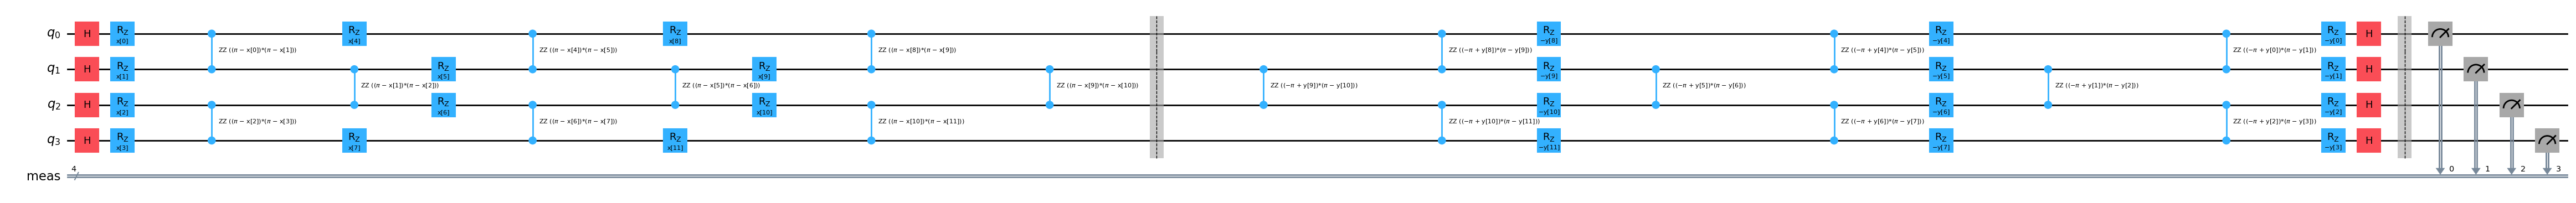

In [6]:
circuits[0].draw("mpl", fold=-1)

In the standard Qiskit Pattern workflow, parameter values are typically passed to Sampler or Estimator as part of PUB.
However, when using a backend that supports fractional gates, these parameter values must be explicitly assigned to the quantum circuit prior to transpilation.

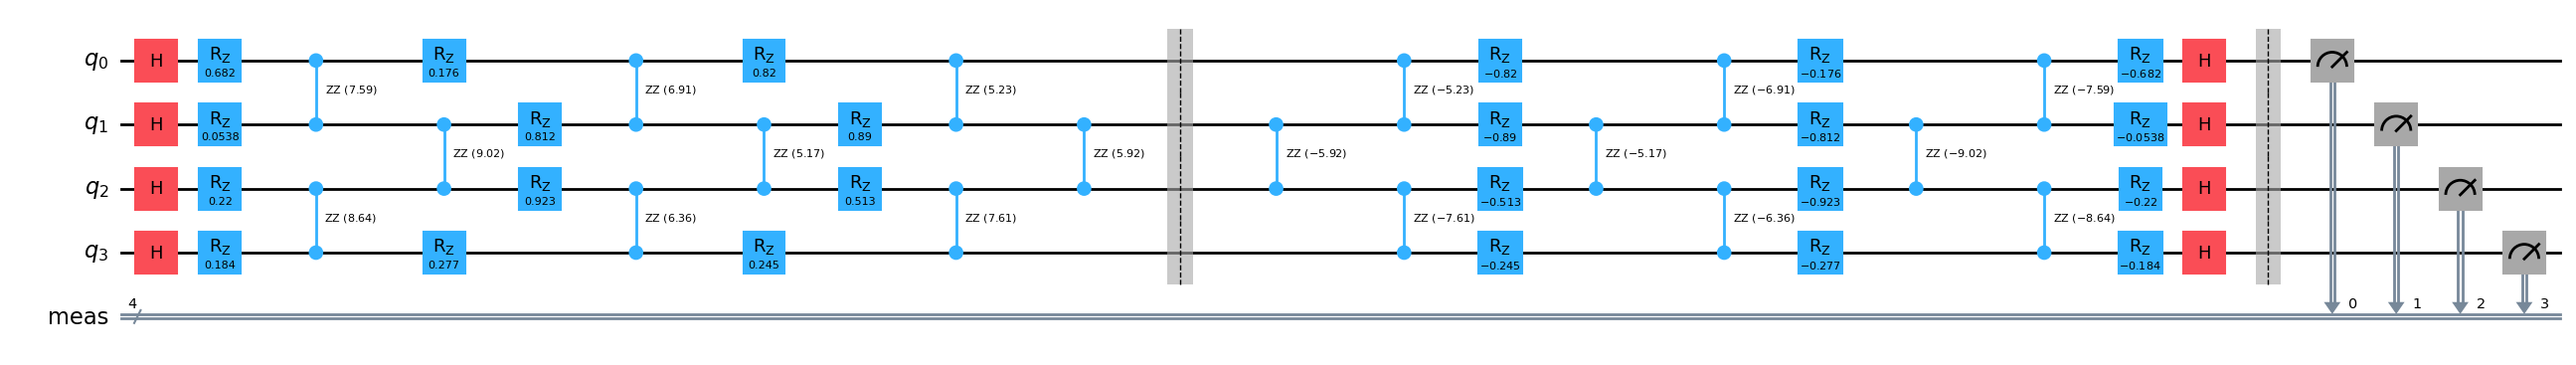

In [7]:
b_qc = [circ.assign_parameters(param) for circ, param in zip(circuits, params)]
b_qc[0].draw("mpl", fold=-1)

### Step 2: Optimize problem for quantum hardware execution

We then transpile the circuit using the pass manager following the standard Qiskit Pattern.
By providing a backend that supports fractional gates to `generate_preset_pass_manager`, a specialized pass called `FoldRzzAngle` is automatically included.
This pass modifies the circuit to comply with the RZZ angle constraints.
As a result, RZZ gates with negative values in the previous figure are transformed into positive values and some additional X gates are added.

In [8]:
backend_f = service.backend(name=backend_name, use_fractional_gates=True)
# pm_f includes `FoldRzzAngle` pass
pm_f = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_f)

OrderedDict({'rz': 35, 'rzz': 18, 'x': 13, 'rx': 9, 'measure': 4, 'barrier': 2})


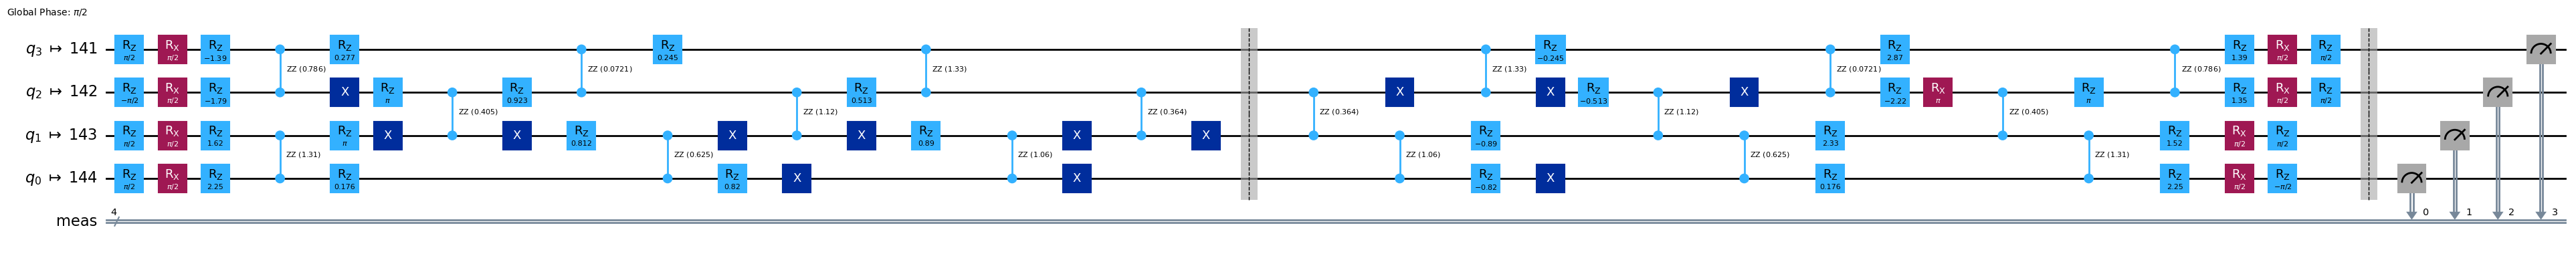

In [9]:
t_qc_f = pm_f.run(b_qc)
print(t_qc_f[0].count_ops())
t_qc_f[0].draw("mpl", fold=-1)

To assess the impact of fractional gates, we evaluate the number of non-local gates (CZ and RZZ for this backend),
along with circuit depths and durations, and compare these metrics to those from a standard workflow later.

In [10]:
nnl_f = [qc.num_nonlocal_gates() for qc in t_qc_f]
depth_f = [qc.depth() for qc in t_qc_f]
duration_f = [qc.estimate_duration(backend_f.target, unit="u") for qc in t_qc_f]

### Step 3: Execute using Qiskit primitives

We run the transpiled circuit with the backend that supports fractional gates.

In [11]:
sampler_f = SamplerV2(mode=backend_f)
sampler_f.options.dynamical_decoupling.enable = True
sampler_f.options.dynamical_decoupling.sequence_type = "XY4"
sampler_f.options.dynamical_decoupling.skip_reset_qubits = True

In [12]:
job = sampler_f.run(t_qc_f, shots=shots)
print(job.job_id())

d1obougt0npc73flhiag


### Step 4: Post-process and return result in desired classical format

You can obtain the kernel function value $K(x, x)$ by measuring the probability of the all-zero bitstring `00...00` in the output.

In [13]:
# job = service.job("d1obougt0npc73flhiag")
result = job.result()
fidelity_f = [fidelity(result=res) for res in result]
print(fidelity_f)
usage_f = job.usage()

[0.889, 0.69, 0.497, 0.3735, 0.301, 0.2225, 0.167, 0.011, 0.0265, 0.0155]


## Comparison of workflow and circuit without fractional gates

In this section, we present the the standard Qiskit pattern workflow using a backend that does not support fractional gates.
By comparing the transpiled circuits, you will notice that the version using fractional gates (from the previous section) is more compact than the one without fractional gates.

In [14]:
# step 1: map classical inputs to quantum problem
# `circuits` and `params` from the previous section are reused here

OrderedDict({'rz': 130, 'sx': 80, 'cz': 36, 'measure': 4, 'barrier': 2})


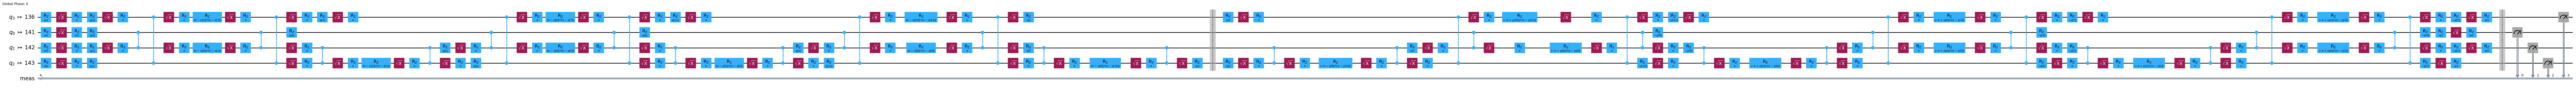

In [15]:
# step 2: optimize circuits
backend_c = service.backend(backend_name)  # w/o fractional gates
pm_c = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_c)
t_qc_c = pm_c.run(circuits)
print(t_qc_c[0].count_ops())
t_qc_c[0].draw("mpl", fold=-1)

In [16]:
nnl_c = [qc.num_nonlocal_gates() for qc in t_qc_c]
depth_c = [qc.depth() for qc in t_qc_c]
duration_c = [qc.estimate_duration(backend_c.target, unit="u") for qc in t_qc_c]

In [17]:
# step 3: execute
sampler_c = SamplerV2(backend_c)
sampler_c.options.dynamical_decoupling.enable = True
sampler_c.options.dynamical_decoupling.sequence_type = "XY4"
sampler_c.options.dynamical_decoupling.skip_reset_qubits = True

In [18]:
job = sampler_c.run(pubs=zip(t_qc_c, params), shots=shots)
print(job.job_id())

d1obp8j3rr0s73bg4810


In [19]:
# step 4: post-processing
# job = service.job("d1obp8j3rr0s73bg4810")
result = job.result()
fidelity_c = [fidelity(res) for res in result]
print(fidelity_c)
usage_c = job.usage()

[0.765, 0.3685, 0.241, 0.1695, 0.076, 0.0815, 0.054, 0.002, 0.006, 0.011]


## Comparison of depths and fidelities

In this section, we compare the number of non-local gates and the fidelities between circuits with and without fractional gates.
This highlights the potential benefits of using fractional gates in terms of execution efficiency and quality.

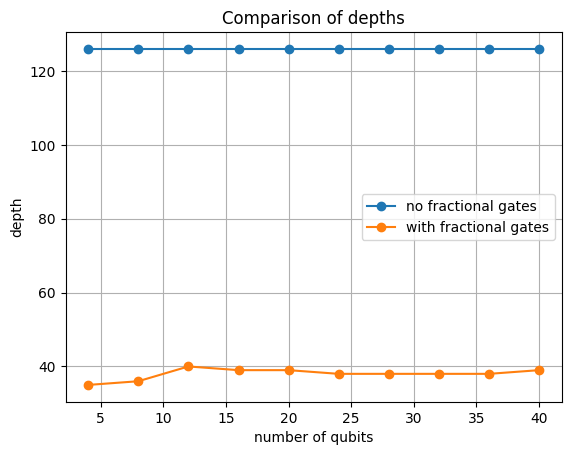

In [20]:
plt.plot(qubits, depth_c, "-o", label="no fractional gates")
plt.plot(qubits, depth_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("depth")
plt.title("Comparison of depths")
plt.grid()
plt.legend()

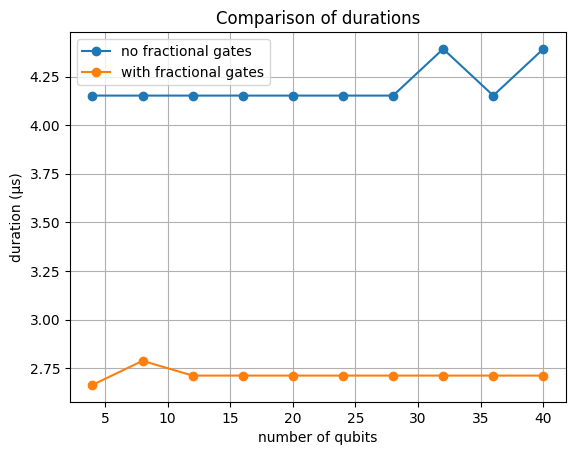

In [21]:
plt.plot(qubits, duration_c, "-o", label="no fractional gates")
plt.plot(qubits, duration_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("duration (µs)")
plt.title("Comparison of durations")
plt.grid()
plt.legend()

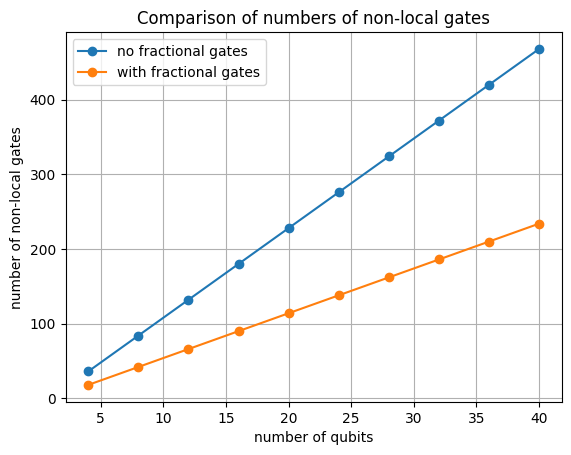

In [22]:
plt.plot(qubits, nnl_c, "-o", label="no fractional gates")
plt.plot(qubits, nnl_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("number of non-local gates")
plt.title("Comparison of numbers of non-local gates")
plt.grid()
plt.legend()

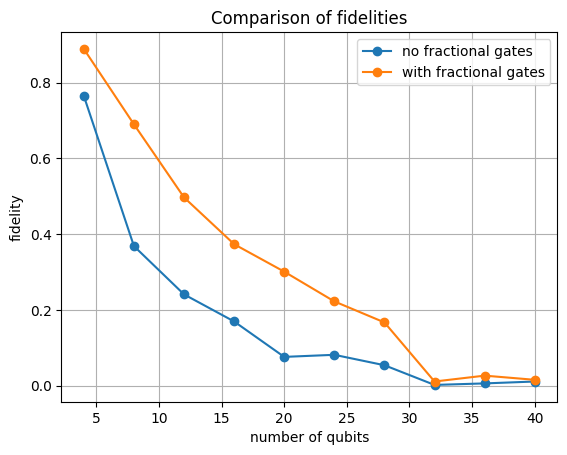

In [23]:
plt.plot(qubits, fidelity_c, "-o", label="no fractional gates")
plt.plot(qubits, fidelity_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("fidelity")
plt.title("Comparison of fidelities")
plt.grid()
plt.legend()

We compare the QPU usage time with and without fractional gates. The results in the following cell shows the QPU usage times are almost identical.

In [24]:
print(f"no fractional gates: {usage_c} seconds")
print(f"fractional gates: {usage_f} seconds")

no fractional gates: 11 seconds
fractional gates: 11 seconds


## Advanced topic: Using only fractional RX gates

The need for the modified workflow when using fractional gates primarily stems from the restriction on RZZ gate angles.
However, if you use only the fractional RX gates and exclude the fractional RZZ gates, you can continue to follow the standard Qiskit Pattern workflow.
This approach can still offer meaningful benefits, particularly in circuits that involve a large number of RX gates and U gates, by reducing the overall gate count and potentially improving performance.
In this section, we demonstrate how to optimize your circuits using only fractional RX gates, while omitting RZZ gates.

To support this, we provide a utility function that allows you to disable a specific basis gate in a Target object.
Here, we use it to disable RZZ gate.

In [25]:
from qiskit.circuit.library import n_local
from qiskit.transpiler import Target

In [26]:
def remove_instruction_from_target(target: Target, gate_name: str) -> Target:
    new_target = Target(
        description=target.description,
        num_qubits=target.num_qubits,
        dt=target.dt,
        granularity=target.granularity,
        min_length=target.min_length,
        pulse_alignment=target.pulse_alignment,
        acquire_alignment=target.acquire_alignment,
        qubit_properties=target.qubit_properties,
        concurrent_measurements=target.concurrent_measurements,
    )

    for name, qarg_map in target.items():
        if name == gate_name:
            continue
        instruction = target.operation_from_name(name)
        new_target.add_instruction(instruction, qarg_map, name=name)
    return new_target

We use a circuit consisting of U, CZ, and RZZ gates as an example.

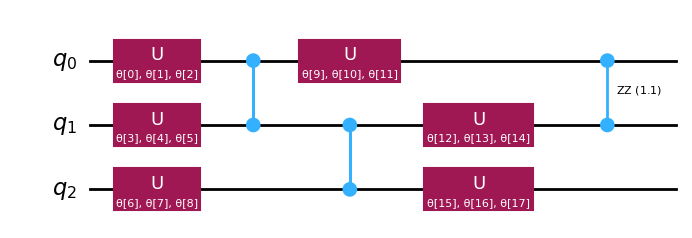

In [27]:
qc = n_local(3, "u", "cz", "linear", reps=1)
qc.rzz(1.1, 0, 1)
qc.draw("mpl")

We first transpile the circuit for a backend that does not support fractional gates.

OrderedDict({'rz': 23, 'sx': 16, 'cz': 4})


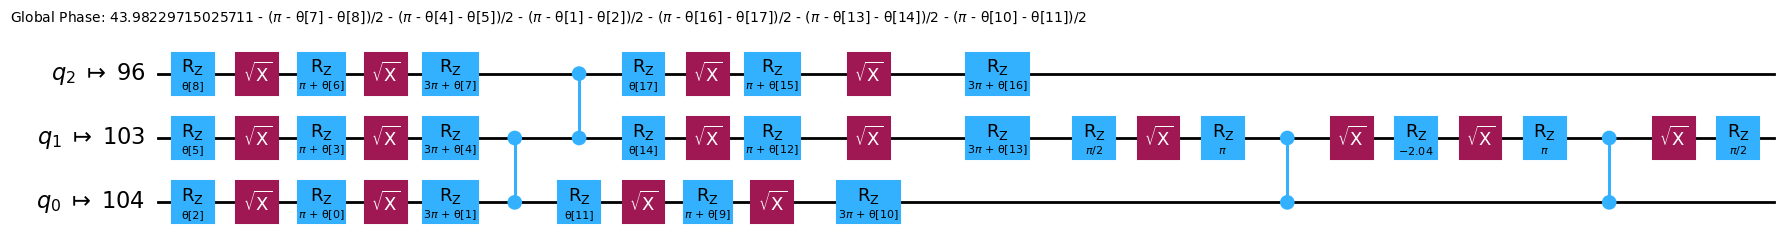

In [28]:
pm_c = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_c)
t_qc = pm_c.run(qc)
print(t_qc.count_ops())
t_qc.draw("mpl")

Then, we transpile the same circuit using fractional RX gates, while excluding RZZ gates.
This results in a slight reduction in the total gate count, thanks to the more efficient implementation of the RX gates.

OrderedDict({'rz': 22, 'sx': 14, 'cz': 4, 'rx': 1})


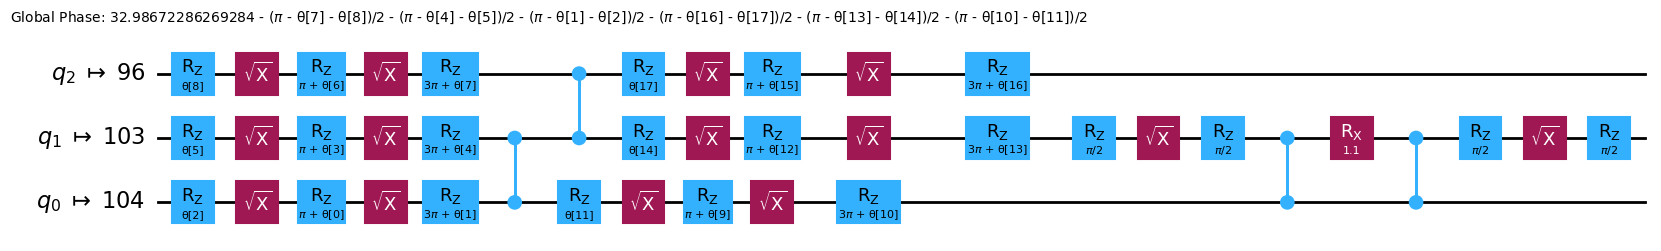

In [29]:
backend_f = service.backend(backend_name, use_fractional_gates=True)
target = remove_instruction_from_target(backend_f.target, "rzz")
pm_f = generate_preset_pass_manager(
    optimization_level=optimization_level,
    target=target,
)
t_qc = pm_f.run(qc)
print(t_qc.count_ops())
t_qc.draw("mpl")

### Optimizing U gates with fractional RX gates

In this section, we demonstrate how to optimize U gates using fractional RX gates, building on the same circuit introduced in the previous section.

You will need to install `qiskit-basis-constructor` [package](https://github.com/Qiskit/qiskit-basis-constructor) in this section.
This is a beta version of a new transpilation plugin for Qiskit, which may be integrated into Qiskit in the future.

In [30]:
# %pip install qiskit-basis-constructor

In [31]:
from qiskit.circuit.library import UGate
from qiskit_basis_constructor import DEFAULT_EQUIVALENCE_LIBRARY

We transpile the circuit using only fractional RX gates, excluding RZZ gates.
By introducing a custom decomposition rule, as shown below,
we can reduce the number of single-qubit gates required to implement a U gate.

This feature is currently under discussion in https://github.com/Qiskit/qiskit/issues/13455.

In [32]:
# special decomposition rule for UGate
x = ParameterVector("x", 3)
zxz = QuantumCircuit(1)
zxz.rz(x[2] - np.pi / 2, 0)
zxz.rx(x[0], 0)
zxz.rz(x[1] + np.pi / 2, 0)
DEFAULT_EQUIVALENCE_LIBRARY.add_equivalence(UGate(x[0], x[1], x[2]), zxz)

Next, we apply the transpiler using `constructor-beta` translation provided by `qiskit-basis-constructor` package.
As a result, the total number of gates is reduced compare to the previous transpilation.

OrderedDict({'rz': 16, 'rx': 9, 'cz': 4})


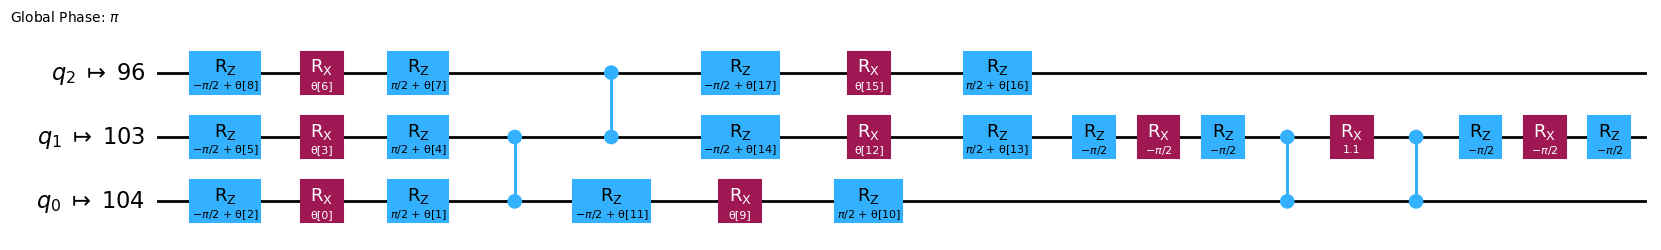

In [33]:
pm_f = generate_preset_pass_manager(
    optimization_level=optimization_level,
    target=target,
    translation_method="constructor-beta",
)
t_qc = pm_f.run(qc)
print(t_qc.count_ops())
t_qc.draw("mpl")

## Troubleshooting

### Issue: Invalid RZZ angles may remain after transpilation

As of Qiskit 2.0.3, there are known issues where RZZ gates with invalid angles may remain in the circuits even after transpilation.
The issue typically arises under the following conditions.

#### Failure when using `target` option with `generate_preset_pass_manager` or `transpiler`

When the `target` option is used with `generate_preset_pass_manager` or `transpiler`, the specialized transpiler pass `FoldRzzAngle` is not invoked.
To ensure proper handling of RZZ angles for fractional gates, we recommend always using the `backend` option instead.
For more details, see https://github.com/Qiskit/qiskit/issues/14318.

#### Failure when circuits contain certain gates (e.g., `XXPlusYYGate`)

If your circuit includes certain gates such as `XXPlusYYGate`, Qiskit transpiler may generate RZZ gates with invalid angles.
If you encounter this issue, a workaround is available at https://github.com/Qiskit/qiskit-ibm-runtime/issues/2256#issuecomment-2889487152.

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td valign="top" style="width: 10%;"><img src="https://your.feedback.ibm.com/jfe/form/SV_cCNiGkGX5xZMzoG" alt="Survey" width="100%" height="100%"></td>
<td valign="top" style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_cCNiGkGX5xZMzoG" target="_blank">Tutorial Survey</a></strong><p><p>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>

© IBM Corp. 2025